<a href="https://colab.research.google.com/github/liamhall64/Habitable-Exomoons/blob/main/Light_Curve_Simulations_Earth_160924.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytransit celerite emcee corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.0/308.0 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.1/698.1 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.6 MB/s eta 0:00:00


In [3]:
from pytransit import QuadraticModel
# from pytransit import UniformModel
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const

/usr/local/lib/python3.10/dist-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [4]:
timings = [0, -115.31152, 156.33668, -96.646134, -25.306092, 130.95555, -152.2404]*u.s
ttvp = timings.to(u.day)

Earth Light Curve

"\nplt.grid(True)\nplt.title('Light Curve Simulation for Earth')\nplt.ylabel('Relative signal')\nplt.xlabel('Time (days)')\nplt.show();\n\n\nplt.figure(figsize=(17, 12))  # Adjust figure size as needed\n\nfor i in range(len(ttvp)):\n  plt.subplot(3, 3, i + 1)  # Create subplots in a 3x3 grid\n  plt.plot(t, lc_Earth[i], '-o')\n  plt.grid(True)\n  plt.title(f'ttvp = {ttvp[i].to(u.s):.2f}')  # Set title with ttvp value\n  plt.ylabel('Relative signal')\n  plt.xlabel('Time (days)')\n\nplt.tight_layout()\n#plt.show()\n"

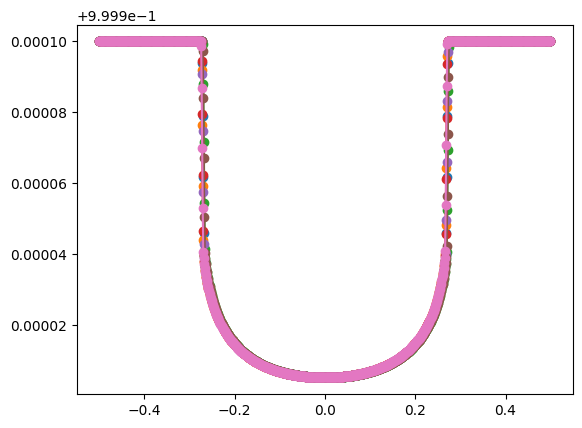

In [5]:
# SWAPPED THE t0 FOR ttvp FOR THE TIME OF INFERIOR CONJUNCTION IN DAYS TO RUN IN A LOOP TO GET MULTIPLE LIGHT CURVES
per = 365.25                         #orbital period in days
rp_rs_Earth = const.R_earth/const.R_sun        #planet radius / stellar radius ratio
ars =  const.au/const.R_sun              #semi-major axis / stellar radius ratio
inc =  (90*u.deg).to(u.rad).value    #orbital inclination (in radians)
ecc = 0.                             #eccentricity
w = (90*u.deg).to(u.rad).value       #longitude of periastron (in radians)
gamma = [0.231, 0.226]                 #limb darkening coefficients [u1, u2]

texp = 100*u.s.to(u.day)             # the exposure time : we convert seconds to days
t = np.arange(-0.5, 0.5, texp)       # new timegrid #note we use np.arange rather than np.linspace (DAYS) MANDEL AND........
tm = QuadraticModel()                # a model that uses two limb-darkening coefficients
tm.set_data(t)

#plt.figure('lcEarth')
lc_Earth = []
for i in range(len(ttvp)):
  lc_Earth.append(tm.evaluate(k=rp_rs_Earth, ldc=gamma, t0=ttvp[i], p=per, a=ars, i=inc, e=ecc, w=w))
  plt.plot(t, lc_Earth[i], '-o')

'''
plt.grid(True)
plt.title('Light Curve Simulation for Earth')
plt.ylabel('Relative signal')
plt.xlabel('Time (days)')
plt.show();


plt.figure(figsize=(17, 12))  # Adjust figure size as needed

for i in range(len(ttvp)):
  plt.subplot(3, 3, i + 1)  # Create subplots in a 3x3 grid
  plt.plot(t, lc_Earth[i], '-o')
  plt.grid(True)
  plt.title(f'ttvp = {ttvp[i].to(u.s):.2f}')  # Set title with ttvp value
  plt.ylabel('Relative signal')
  plt.xlabel('Time (days)')

plt.tight_layout()
#plt.show()
'''
#calculate T14 for Earth and input into time steps

Adding Noise

/usr/local/lib/python3.10/dist-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


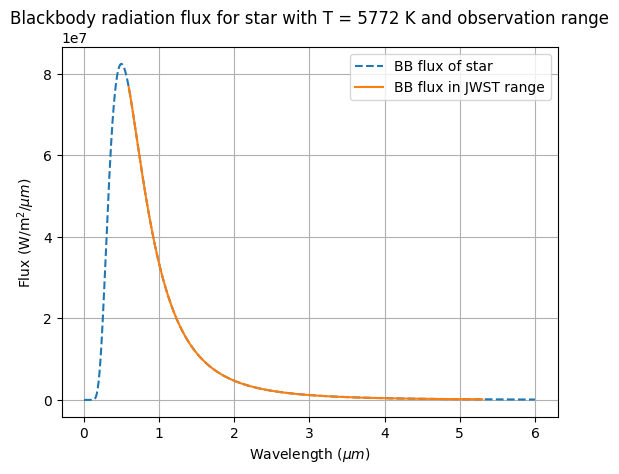

Done


In [6]:
def planck(wl, T):
  a = np.float64(1.191042768e8)*u.um**5 *u.W/ u.m**2 /u.sr/u.um
  b = np.float64(14387.7516)*1*u.um * 1*u.K
  try:
    x = b/(wl*T)
    bb = a/wl**5 / (np.exp(x) - 1.0)
  except ArithmeticError:
    bb = np.zeros(np.size(wl))
  return bb

s_lum, s_rad = 1*const.L_sun, 1*const.R_sun              # STELLAR VALUES
T_s = (s_lum/(4*np.pi*s_rad**2*const.sigma_sb))**0.25    # TEMP-LUMINOSITY RELATIONSHIP

wl = np.linspace(0.6, 5.3, 1000)*u.um                    # JWST NIRSPEC PRISM WAVELENGTH RANGE
wl_full = np.linspace(0,6, 1000)*u.um
BB_flux = np.pi*u.sr*planck(wl,T_s)                      # FLUX DENSITY - W/M^2/MICRONS
BB_flux_full = np.pi*u.sr*planck(wl_full,T_s)
#'''
plt.figure('BB flux of host star')
#plt.figure(figsize=(12, 6))
plt.plot(wl_full,BB_flux_full,'--', label = 'BB flux of star')
plt.plot(wl,BB_flux,label = 'BB flux in JWST range')
plt.title(f'Blackbody radiation flux for star with T = {T_s:.0f} and observation range')
plt.xlabel('Wavelength ($\mu m$)'); plt.ylabel('Flux (W/m$^2$/$\mu m$)')
plt.legend()
plt.grid()
plt.show();
#'''
print('Done')

In [7]:
R_s = 1*u.Rsun.to(u.m) # host star radius in Rsun (code converts this to m)
d = 10*u.pc.to(u.m) # distance to star in pc (code converts this to m)

Flux = BB_flux*(R_s/d)**2

D = 6.5*u.m; Atel = np.pi*(D/2)**2 # APERTURE OF SPECIFIC TELESCOPE
trans = 0.5; QE = 0.8 # QUANTUM EFFICIENCY
Power_per_micron = Flux*Atel*trans*QE # WATTS / MICRON
Power = Power_per_micron*np.gradient(wl) # WATTS

Photons_per_second = Power/(const.h*const.c/wl.to(u.m)) # CONVERT WATTS TO PHOTONS
Photons_per_second = np.sum(Photons_per_second).value*1/u.s # TOTAL ELECTRONS PER SECOND

exposure_time = 100*u.s # GENRALISED EXPOSURE
Electrons = (Photons_per_second*exposure_time).value
std = Electrons**0.5

Noise = Electrons**0.5 # ASSUMING A NOISE LIMITED INSTRUMENT
Noise = np.random.normal(0, Noise, len(lc_Earth[0]))

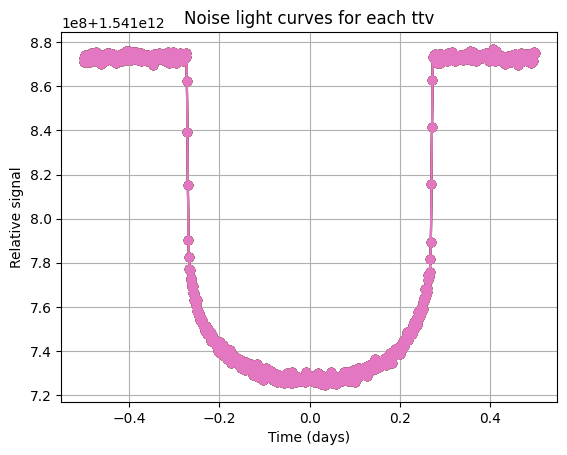

In [8]:
for i in range(len(lc_Earth)):
  lc = lc_Earth[0]*Electrons
  lc = lc + Noise
  plt.plot(t, lc, '-o')
  plt.grid()
  plt.title('Noise light curves for each ttv')
  plt.ylabel('Relative signal')
  plt.xlabel('Time (days)')

plt.show()

Fitted Rp/Rs 0.00916696199137181 Actual Rp/Rs 0.009167888457668536
Fitted S 1541873329438.4521 Actual S 1541873399520.7236
Fitted t0 -1.8063455796771243e-05 Actual t0 [ 0.         -0.00133462  0.00180945 -0.00111859 -0.00029289  0.00151569
 -0.00176204] d


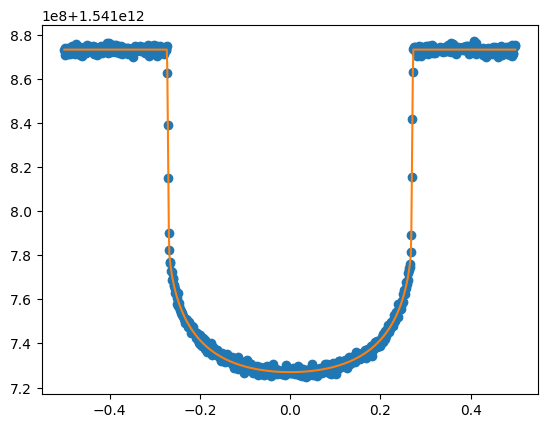

In [9]:
def chi_squared(X, lc, Noise):
    rp_rs = X[0]
    S = X[1]
    t_0 = X[2]
    model =tm.evaluate(k=rp_rs, ldc=gamma, t0=t_0, p=per, a=ars, i=inc, e=ecc, w=w) *S
    return np.sum(((model-lc))**2/Noise**2)

t0 = ttvp
data_lc = lc
S= Electrons

fit_init = [((lc.max()-lc.min())/ lc.max())**0.5, np.mean(lc[0:40]), t0.value[0]+np.random.normal(0,0.001)] # these are initial guesses - we'll cheat a bit by putting in the known values but you can try starting with different initial values too
# Access the first element of t0.value to ensure it's a scalar
bounds =((rp_rs_Earth*0.99,rp_rs_Earth*1.1), (S*0.99,S*1.1), (-0.01,0.01)) # the bounds over which the algorithm will vary the parameters
# Use std instead of Noise
fit  = minimize(chi_squared, fit_init, args=(data_lc, std), method='Nelder-Mead', jac=None, hess=None, hessp=None, bounds=bounds, constraints=(), tol=None, callback=None, options=None)
final_fit = [fit['x'][0], fit['x'][1], fit['x'][2]]
print ('Fitted Rp/Rs', final_fit[0], 'Actual Rp/Rs', rp_rs_Earth)
print ('Fitted S', final_fit[1], 'Actual S', S)
print ('Fitted t0', final_fit[2], 'Actual t0', t0)

model_fit = tm.evaluate(k=fit['x'][0], ldc=gamma, t0=fit['x'][2], p=per, a=ars, i=inc, e=ecc, w=w) *fit['x'][1]

plt.figure('lc')
plt.plot(t,data_lc, 'o')
plt.plot(t,model_fit, '-')
plt.show();

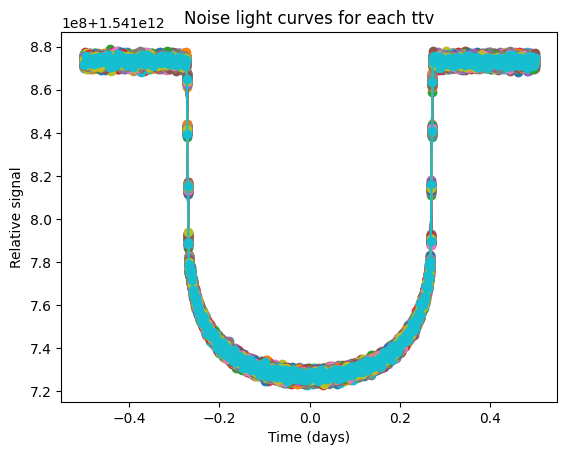

In [10]:
t0_list = []
observations = 100
for i in range(observations):
  Noise = Electrons**0.5 # ASSUMING A NOISE LIMITED INSTRUMENT
  Noise = (np.random.normal(0, Noise, len(lc_Earth[0])))

  lc = lc_Earth[0]*Electrons
  lc = lc + Noise
  plt.plot(t, lc, '-o')
  plt.grid()
  plt.title('Noise light curves for each ttv')
  plt.ylabel('Relative signal')
  plt.xlabel('Time (days)')

  t0 = ttvp
  data_lc = lc
  S = Electrons

  fit_init = [((lc.max()-lc.min())/ lc.max())**0.5, np.mean(lc[0:40]), t0.value[0]+np.random.normal(0,0.001)] # these are initial guesses - we'll cheat a bit by putting in the known values but you can try starting with different initial values too
  # Access the first element of t0.value to ensure it's a scalar
  bounds =((rp_rs_Earth*0.99,rp_rs_Earth*1.1), (S*0.99,S*1.1), (-0.01,0.01)) # the bounds over which the algorithm will vary the parameters
  # Use std instead of Noise
  fit  = minimize(chi_squared, fit_init, args=(data_lc, std), method='Nelder-Mead', jac=None, hess=None, hessp=None, bounds=bounds, constraints=(), tol=None, callback=None, options=None)
  final_fit = [fit['x'][0], fit['x'][1], fit['x'][2]]
  #print ('Fitted Rp/Rs', final_fit[0], 'Actual Rp/Rs', rp_rs_Earth)
  #print ('Fitted S', final_fit[1], 'Actual S', S)
  #print ('Fitted t0', final_fit[2], 'Actual t0', t0)

  model_fit = tm.evaluate(k=fit['x'][0], ldc=gamma, t0=fit['x'][2], p=per, a=ars, i=inc, e=ecc, w=w) *fit['x'][1]

  #plt.figure('lc')
  #plt.plot(t,data_lc, 'o')
  #plt.plot(t,model_fit, '-')

  t0_list.append(final_fit[2])

#plt.show()


In [11]:
t0_list_sec = [t*u.day.to(u.s) for t in t0_list]
std = np.std(t0_list_sec)
mean = np.mean(t0_list_sec)

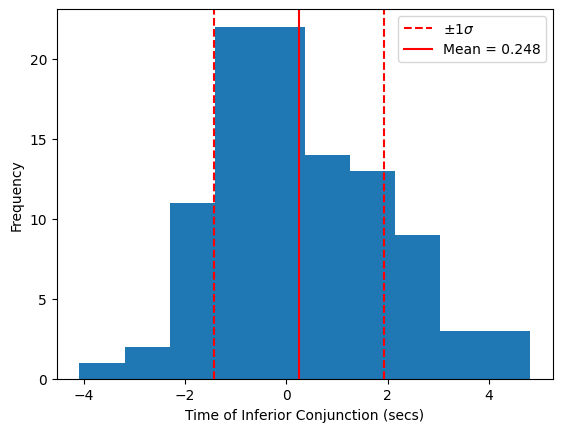

In [12]:
plt.hist(t0_list_sec)
plt.axvline(mean + std, c = 'r', linestyle = '--')
plt.axvline(mean - std, c = 'r', linestyle = '--', label = '$\pm 1 \sigma$')
plt.axvline(np.mean(t0_list_sec), c = 'r', label = f'Mean = {np.mean(t0_list_sec):.3f}')

plt.xlabel('Time of Inferior Conjunction (secs)')
plt.ylabel('Frequency')
plt.legend()

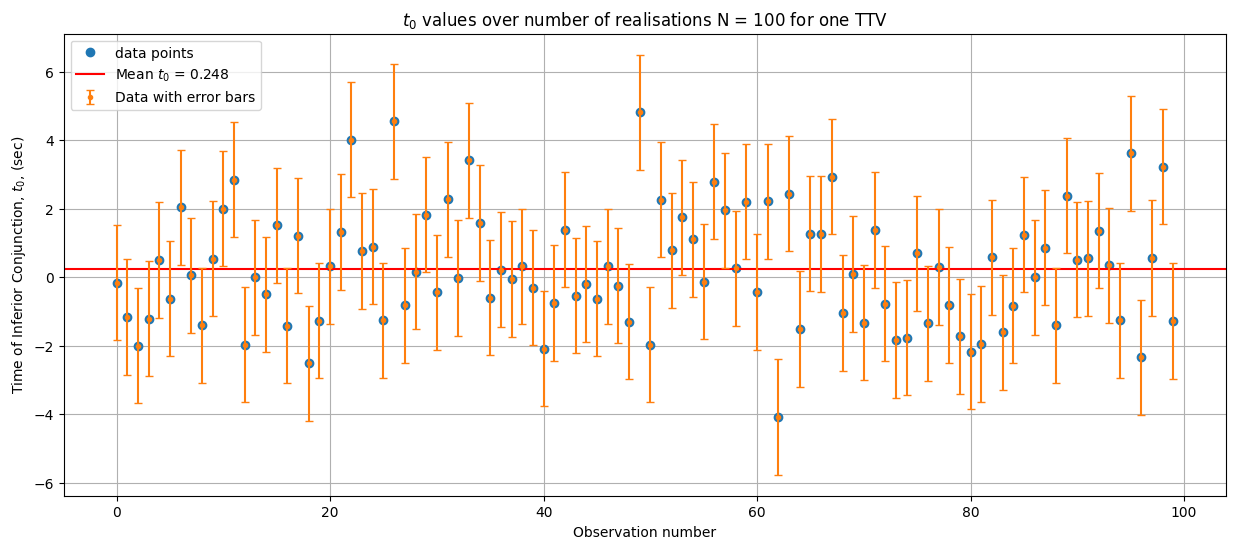

In [24]:
plt.figure(figsize=(15, 6))

plt.plot(range(len(t0_list_sec)), t0_list_sec, 'o', label = 'data points')
plt.axhline(np.mean(t0_list_sec), c = 'r', label = f'Mean $t_0$ = {np.mean(t0_list_sec):.3f}')
plt.errorbar(range(len(t0_list_sec)), t0_list_sec, yerr = std, fmt = '.', capsize = 3, label = 'Data with error bars')
plt.legend()

plt.xlabel('Observation number')
plt.ylabel('Time of Inferior Conjunction, $t_0$, (sec)')
plt.title(f'$t_0$ values over number of realisations N = {len(t0_list_sec)} for one TTV')
plt.grid()

The graph above plots the fitted $t_0$ values using random noise and compares them with the mean $t_0$.

The standard deviation (STD) is then used as the error on a

In [26]:
flagged = []
for i in range(len(t0_list_sec)):
  if t0_list_sec[i] >= std or np.abs(t0_list_sec[i]) >= std:
    flagged.append(i)
print(f'Standard deviation = {std:.3f}')

Standard deviation = 1.684
